In [14]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader



Keys in the HDF5 file: ['p230', 'p253', 'p288', 'p335', 'p336']
Dataset Shape: (397, 1507, 80)
Dataset Datatype: float32


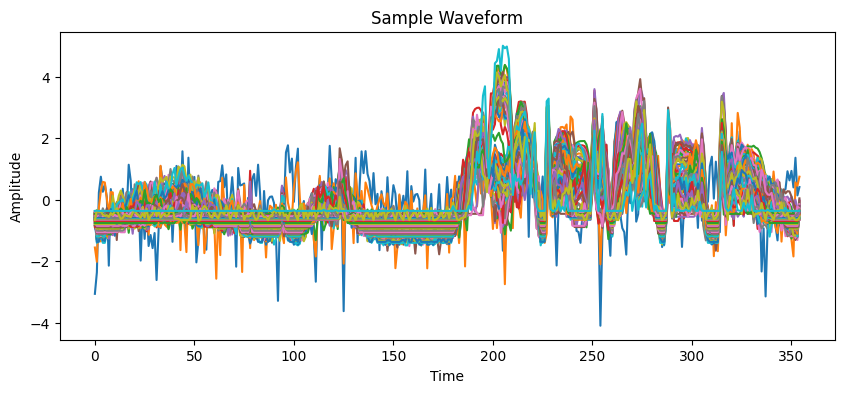

In [3]:

dataset_path = '/data/common_source/datasets/processed_spectrograms_test.h5'

# Check if the file exists
if not os.path.exists(dataset_path):
    print("File does not exist. Double-check the path.")
else:
    # Print the keys in the HDF5 file
    with h5py.File(dataset_path, 'r') as hf:
        print("Keys in the HDF5 file:", list(hf.keys()))

        # Choose one of the keys as the dataset name (let's use 'p230' as an example)
        dataset_name = 'p230'

        # Assuming your data is stored in the chosen dataset
        data = hf[dataset_name][:]

        # Explore the dataset
        print("Dataset Shape:", data.shape)
        print("Dataset Datatype:", data.dtype)

        # Plot a sample waveform
        sample_waveform = data[0]  # Adjust the index as needed
        plt.figure(figsize=(10, 4))
        plt.plot(sample_waveform)
        plt.title("Sample Waveform")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.show()


In [4]:



# Check if the file exists
if not os.path.exists(dataset_path):
    print("File does not exist. Double-check the path.")
else:
    # Print the keys and shapes of all datasets in the HDF5 file
    with h5py.File(dataset_path, 'r') as hf:
        print("Keys and Shapes of Datasets in the HDF5 file:")
        for key in hf.keys():
            dataset = hf[key]
            print(f"\nKey: {key}")
            print("Dataset Shape:", dataset.shape)
            print("Dataset Datatype:", dataset.dtype)


Keys and Shapes of Datasets in the HDF5 file:

Key: p230
Dataset Shape: (397, 1507, 80)
Dataset Datatype: float32

Key: p253
Dataset Shape: (375, 1136, 80)
Dataset Datatype: float32

Key: p288
Dataset Shape: (412, 1133, 80)
Dataset Datatype: float32

Key: p335
Dataset Shape: (422, 1549, 80)
Dataset Datatype: float32

Key: p336
Dataset Shape: (418, 1361, 80)
Dataset Datatype: float32


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:


class LayerNormalizedGatedConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation):
        super(LayerNormalizedGatedConv1d, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, dilation)
        self.ln = nn.LayerNorm(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = F.glu(x, dim=1)
        x = self.ln(x)
        return x

class LayerNormalizedLReLUConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation):
        super(LayerNormalizedLReLUConv1d, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, dilation)
        self.ln = nn.LayerNorm(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        x = self.ln(x)
        return x

class LayerNormalizedGatedTransposeConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, output_padding, dilation):
        super(LayerNormalizedGatedTransposeConv1d, self).__init__()
        self.deconv = nn.ConvTranspose1d(in_channels, out_channels * 2, kernel_size, stride, padding, output_padding, dilation)
        self.ln = nn.LayerNorm(out_channels)

    def forward(self, x):
        x = self.deconv(x)
        x = F.glu(x, dim=1)
        x = self.ln(x)
        return x

class LayerNormalizedLReLUTransposeConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, output_padding, dilation):
        super(LayerNormalizedLReLUTransposeConv1d, self).__init__()
        self.deconv = nn.ConvTranspose1d(in_channels, out_channels, kernel_size, stride, padding, output_padding, dilation)
        self.ln = nn.LayerNorm(out_channels)

    def forward(self, x):
        x = self.deconv(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        x = self.ln(x)
        return x
class Generator(nn.Module):
    """
    Generator or Decoder in the VAE using transposed 1-dimensional convolutions.
    """
    def __init__(self, input_shape, kernel_sizes, strides, dilations, paddings, 
                out_paddings, num_output_channels, convolution_layer=LayerNormalizedGatedTransposeConv1d):
        super(Generator, self).__init__()
        self.input_shape = input_shape
        self.kernel_sizes = kernel_sizes
        self.strides = strides
        self.dilations = dilations
        self.paddings = paddings
        self.out_paddings = out_paddings
        self.num_output_channels = num_output_channels

        self.layer_dict = nn.ModuleDict()
        self.build_module(convolution_layer)

    def build_module(self, convolution_layer):
        num_layers = len(self.kernel_sizes)
        print('Building Decoder/Generator with {} upsampling layers.'.format(num_layers))

        x = torch.zeros((self.input_shape))

        print(x.shape)
        # Upsampling convolutions
        for i in range(num_layers-1):
            conv = convolution_layer(input_shape=x.shape,
                        in_channels=x.shape[1],
                        out_channels=self.num_output_channels[i],
                        kernel_size=self.kernel_sizes[i],
                        stride=self.strides[i],
                        dilation=self.dilations[i],
                        padding=self.paddings[i],
                        out_padding=self.out_paddings[i])
            self.layer_dict['conv_{}'.format(i)] = conv
            x = conv(x)
            print(x.shape)

        self.final_conv = nn.ConvTranspose1d(in_channels=x.shape[1],
                                    out_channels=self.num_output_channels[-1],
                                    kernel_size=self.kernel_sizes[-1],
                                    stride=self.strides[-1],
                                    dilation=self.dilations[-1],
                                    padding=self.paddings[-1],
                                    output_padding=self.out_paddings[-1])
        x = self.final_conv(x)
        print(x.shape)

    def forward(self, input):
        num_layers = len(self.kernel_sizes)

        out = input
        for i in range(num_layers-1):
            out = self.layer_dict['conv_{}'.format(i)](out)

        out = self.final_conv(out)

        return out

    def reset_parameters(self):
        """
        Re-initializes the networks parameters
        """
        for item in self.layer_dict.children():
            item.reset_parameters()
        
        self.final_conv.reset_parameters()



class Encoder(nn.Module):
    """
    Downsampling encoder with strided convolutions.
    """
    def __init__(self, input_shape, kernel_sizes, strides, num_output_channels, 
                paddings, dilations, convolution_layer=LayerNormalizedGatedConv1d):
        super(Encoder, self).__init__()
        self.input_shape = input_shape
        self.kernel_sizes = kernel_sizes
        self.strides = strides
        self.num_output_channels = num_output_channels
        self.paddings = paddings
        self.dilations = dilations

        self.layer_dict = nn.ModuleDict()
        self.build_module(convolution_layer=convolution_layer)


    def build_module(self, convolution_layer):
        num_layers = len(self.kernel_sizes)
        print('Building Encoder with {} downsampling layers.'.format(num_layers))

        x = torch.zeros((self.input_shape))

        print(x.shape)
        # Downsampling convolutions
        for i in range(num_layers-1):
            conv = convolution_layer(input_shape=x.shape,
                                    in_channels=x.shape[1],
                                    out_channels=self.num_output_channels[i],
                                    kernel_size=self.kernel_sizes[i],
                                    stride=self.strides[i],
                                    padding=self.paddings[i],
                                    dilation=self.dilations[i])
            self.layer_dict['conv_{}'.format(i)] = conv

            x = conv(x)
            print(x.shape)
        
        self.final_conv = nn.Conv1d(in_channels=x.shape[1],
                                out_channels=self.num_output_channels[-1],
                                kernel_size=self.kernel_sizes[-1],
                                stride=self.strides[-1],
                                dilation=self.dilations[-1],
                                padding=self.paddings[-1])
        x = self.final_conv(x)
        print(x.shape)

    def forward(self, input):
        out = input
        for i in range(len(self.kernel_sizes)-1):
            out = self.layer_dict['conv_{}'.format(i)](out)

        out = self.final_conv(out)
        return out

    def reset_parameters(self):
        """
        Re-initializes the networks parameters
        """
        for item in self.layer_dict.children():
            item.reset_parameters()
        
        self.final_conv.reset_parameters()



class QuantisedInputModuleWrapper(nn.Module):
    """
    Wrapper for any module that should take quantised (mu-law encoded) inputs
    """
    def __init__(self, num_input_quantization_channels, model):
        super(QuantisedInputModuleWrapper, self).__init__()
        print('Building Quantised input module.')
        self.d2a = Digital2Analog(num_input_quantization_channels)
        self.model = model
    
    def forward(self, digital_input, speaker):
        analog_input = self.d2a(digital_input)
        return self.model(analog_input, speaker)
    
    def reset_parameters(self):
        self.d2a.reset_parameters()
        self.model.reset_parameters()







In [9]:

class VAE(nn.Module):
    def __init__(self, input_shape, encoder_arch, generator_arch, latent_dim,
                num_speakers, speaker_dim, use_gated_convolutions=False):
        super(VAE, self).__init__()
        self.input_shape = input_shape
        self.encoder_arch = encoder_arch
        self.latent_dim = latent_dim
        self.generator_arch = generator_arch
        self.num_speakers = num_speakers
        self.speaker_dim = speaker_dim
        self.use_gated_convolutions = use_gated_convolutions

        self.speaker_dict = nn.Embedding(num_embeddings=self.num_speakers,
                                        embedding_dim=self.speaker_dim)

        self.build_module()

    def build_module(self):
        print('Building VAE.')
        x = torch.zeros((self.input_shape))

        if self.use_gated_convolutions:
            self.encoder = Encoder(input_shape=self.input_shape,
                                kernel_sizes=self.encoder_arch.kernel_sizes,
                                strides=self.encoder_arch.strides,
                                num_output_channels=self.encoder_arch.num_output_channels,
                                paddings=self.encoder_arch.paddings,
                                dilations=self.encoder_arch.dilations,
                                convolution_layer=LayerNormalizedGatedConv1d)
        else:
            self.encoder = Encoder(input_shape=self.input_shape,
                                kernel_sizes=self.encoder_arch.kernel_sizes,
                                strides=self.encoder_arch.strides,
                                num_output_channels=self.encoder_arch.num_output_channels,
                                paddings=self.encoder_arch.paddings,
                                dilations=self.encoder_arch.dilations,
                                convolution_layer=LayerNormalizedLReLUConv1d)
        z_e = self.encoder(x)
        self.z_e_shape = z_e.shape

        # Flatten z_e
        z_e = z_e.view(z_e.shape[0], -1)

        # Mean of the posterior
        self.mean_dense = nn.Linear(in_features=z_e.shape[1], out_features=self.latent_dim)
        mean = self.mean_dense(z_e)
        print('mean shape: {}'.format(mean.shape))

        # Log-variance of the posterior
        self.logvar_dense = nn.Linear(in_features=z_e.shape[1], out_features=self.latent_dim)
        logvar = self.logvar_dense(z_e)
        print('logvar shape: {}'.format(logvar.shape))

        # Sample latent from the posterior
        z = self.sample_latent(mean, logvar)
        print('latent shape: {}'.format(z.shape))

        self.latent_dense = nn.Linear(in_features=z.shape[1], out_features=self.z_e_shape[1]*self.z_e_shape[2])
        z = self.latent_dense(z)
        print('latent_out shape: {}'.format(z.shape))

        # Speaker conditioning
        y = torch.zeros((self.input_shape[0]), dtype=torch.long)
        y = self.speaker_dict(y)

        self.speaker_dense = nn.Linear(in_features=y.shape[1], out_features=self.z_e_shape[1]*self.z_e_shape[2])
        y = self.speaker_dense(y)
        print('speaker_out shape: {}'.format(y.shape))

        # Add speaker embedding to the latent
        z = z+y

        # reshape back to 3D tensor
        z = z.view(self.z_e_shape)
        print('latent_out reshaped: {}'.format(z.shape))

        if self.use_gated_convolutions:
            self.generator = Generator(input_shape=z.shape,
                                    kernel_sizes=self.generator_arch.kernel_sizes,
                                    strides=self.generator_arch.strides,
                                    dilations=self.generator_arch.dilations,
                                    paddings=self.generator_arch.paddings,
                                    out_paddings=self.generator_arch.out_paddings,
                                    num_output_channels=self.generator_arch.num_output_channels,
                                    convolution_layer=LayerNormalizedGatedTransposeConv1d)
        else:
            self.generator = Generator(input_shape=z.shape,
                                    kernel_sizes=self.generator_arch.kernel_sizes,
                                    strides=self.generator_arch.strides,
                                    dilations=self.generator_arch.dilations,
                                    paddings=self.generator_arch.paddings,
                                    out_paddings=self.generator_arch.out_paddings,
                                    num_output_channels=self.generator_arch.num_output_channels,
                                    convolution_layer=LayerNormalizedLReLUTransposeConv1d)

        x_hat = self.generator(z)


    def forward(self, input, speaker):
        z_e = self.encoder(input)

        # Flatten z_e
        z_e = z_e.view(z_e.shape[0], -1)

        # Get variational parameters
        mean = self.mean_dense(z_e)
        logvar = self.logvar_dense(z_e)

        # Sample from posterior if during training, otherwise just pass the variational mean
        if self.training:
            z = self.sample_latent(mean, logvar)
        else:
            z = mean

        # Form latent output, add speaker embeddings
        z = self.latent_dense(z)
        y = self.speaker_dense(self.speaker_dict(speaker))
        z = z + y

        # reshape back to 3D tensor
        z = z.view(-1, self.z_e_shape[1], self.z_e_shape[2])

        x_hat = self.generator(z)

        return x_hat, mean, logvar

    def reset_parameters(self):
        """
        Re-initializes the networks parameters
        """
        self.encoder.reset_parameters()
        self.generator.reset_parameters()
        self.mean_dense.reset_parameters()
        self.logvar_dense.reset_parameters()
        self.latent_dense.reset_parameters()
        self.speaker_dense.reset_parameters()

        self.speaker_dict.reset_parameters()

    def sample_latent(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

In [15]:
class MyDataset(Dataset):
    def __init__(self, dataset_path, key):
        self.dataset_path = dataset_path
        self.key = key

        # Check if the file exists
        if not os.path.exists(dataset_path):
            raise FileNotFoundError("File does not exist. Double-check the path.")

        # Load the HDF5 file
        with h5py.File(dataset_path, 'r') as hf:
            # Assuming your data is stored in the chosen dataset
            self.data = hf[key][:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = torch.tensor(self.data[idx], dtype=torch.float32)
        return sample

# Define the dataset path and key
dataset_path = '/data/common_source/datasets/processed_spectrograms_test.h5'
key = 'p230'  # Choose one of the keys in the HDF5 file

# Create the dataset and DataLoader
dataset = MyDataset(dataset_path, key)
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [16]:

# Loss function for VAE
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (Mean Squared Error or other suitable loss)
    reconstruction_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL Divergence loss
    kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    total_loss = reconstruction_loss + kl_divergence_loss

    return total_loss


# Replace these values with the actual architecture and dimensions you want
encoder_arch = ...
generator_arch = ...
latent_dim = ...
num_speakers = ...
speaker_dim = ...

# Instantiate your VAE model with the correct parameters
vae_model = VAE(input_shape, encoder_arch, generator_arch, latent_dim, num_speakers, speaker_dim)

s

# Choose an optimizer (e.g., Adam)
optimizer = optim.Adam(vae_model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    vae_model.train()
    for batch_idx, data in enumerate(train_loader):
        audio_data, speaker = data  # Modify this line based on your dataset structure

        optimizer.zero_grad()
        
        # Forward pass
        reconstructed_data, mean, logvar = vae_model(audio_data, speaker)
        
        # Calculate loss
        loss = vae_loss(reconstructed_data, audio_data, mean, logvar)
        
        # Backward pass
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

TypeError: __init__() missing 5 required positional arguments: 'encoder_arch', 'generator_arch', 'latent_dim', 'num_speakers', and 'speaker_dim'

In [ ]:
# Assuming you have initialized your VAE model, DataLoader, loss function, and optimizer

num_epochs = 10

for epoch in range(num_epochs):
    for batch_idx, data in enumerate(train_loader):
        audio_data, speaker = data  # Modify this line based on your dataset structure

        optimizer.zero_grad()
        reconstructed_data, mean, logvar = vae(audio_data, speaker)
        
        # Compute your loss (reconstruction loss + KL divergence loss)
        # Add any other custom losses you may have
        
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
